In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import openmc
import os
import openmc.deplete

from openmc import Plot
from dotenv import load_dotenv
from math import pi, sin, cos

load_dotenv()

CROSS_SECTIONS = os.getenv('CROSS_SECTIONS')
CHAIN_FILE = os.getenv('CHAIN_FILE')

openmc.config['cross_sections'] = CROSS_SECTIONS
openmc.config['chain_file'] = CHAIN_FILE

[MWLT-NITRO5LIN:75511] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.MWLT-NITRO5LIN.1000/jf.0/1911029760/shared_mem_cuda_pool.MWLT-NITRO5LIN could be created.
[MWLT-NITRO5LIN:75511] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [4]:
# Define the fuel material
fuel = openmc.Material(name='fuel')
fuel.add_nuclide('U235', 3.7503e-4)
fuel.add_nuclide('U238', 2.2625e-2)
fuel.add_nuclide('O16', 4.6007e-2)

fuel.add_nuclide('I131', 3.0e-5)
fuel.add_nuclide('Cs137', 6.0e-5)
fuel.add_nuclide('Sr90', 3.5e-5)
fuel.add_nuclide('Ba137', 3.0e-5)
fuel.add_nuclide('Zr95', 1.5e-5)
fuel.add_nuclide('Ru106', 1.2e-5)

fuel.add_nuclide('Np237', 5.0e-6)
fuel.add_nuclide('Pu239', 3.0e-6)
fuel.add_nuclide('Pu241', 2.0e-6)
fuel.add_nuclide('Am241', 1.0e-6)
fuel.add_nuclide('Cm245', 1.0e-7)

fuel.set_density('g/cm3', 10.0)

# Define the clad material
clad = openmc.Material(name='zircaloy')
clad.add_element('Zr', 1.0)
clad.set_density('g/cm3', 6.0)

# Define the helium-nitrogen gas material
coolant = openmc.Material(name='helium-nitrogen gas')
coolant.add_nuclide('He4', 1.0)
coolant.add_nuclide('N14', 0.78)
coolant.add_nuclide('N15', 0.22)
coolant.set_density('g/cm3', 0.1785)

# Define the heavy-light water mixture material
moderator = openmc.Material(name='heavy-light water mixture')
moderator.add_nuclide('H1', 1.0)   # Add H1
moderator.add_nuclide('H2', 2.0)   # Add H2
moderator.add_s_alpha_beta('c_D_in_D2O')  # Add S_alpha_beta for D2O
moderator.set_density('g/cm3', 1.11)

In [5]:
# Outer radius of fuel and clad
r_fuel = 0.6122
r_clad = 0.6540

height = 1.0

fuel.volume = pi * (r_fuel**2) * height

# Pressure tube and calendria radii
pressure_tube_ir = 5.16890
pressure_tube_or = 5.60320
calendria_ir = 6.44780
calendria_or = 6.58750

# Radius to center of each ring of fuel pins
ring_radii = np.array([0.0, 1.4885, 2.8755, 4.3305])

In [6]:
# These are the surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(r=r) for r in
               (ring_radii[:-1] + ring_radii[1:]) / 2]

water_cells = []
for i in range(ring_radii.size):
    if i == 0:
        water_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        water_region = +radial_surf[i - 1]
    else:
        water_region = +radial_surf[i - 1] & -radial_surf[i]
        
    water_cells.append(openmc.Cell(fill=moderator, region=water_region))

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

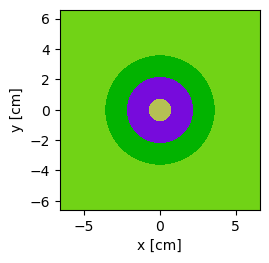

In [7]:
plot_args = {'width': (2*calendria_or, 2*calendria_or)}
bundle_universe = openmc.Universe(cells=water_cells)
bundle_universe.plot(**plot_args)

In [8]:
surf_fuel = openmc.ZCylinder(r=r_fuel)

fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)
clad_cell = openmc.Cell(fill=clad, region=+surf_fuel)

pin_universe = openmc.Universe(cells=(fuel_cell, clad_cell))

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

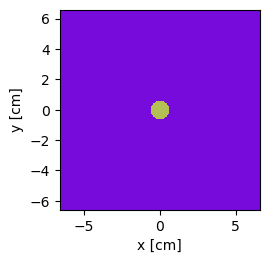

In [9]:
pin_universe.plot(**plot_args)

In [10]:
num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        # Determine location of center of pin
        theta = (a + j/n*360.) * pi/180.
        x = r*cos(theta)
        y = r*sin(theta)
        
        pin_boundary = openmc.ZCylinder(x0=x, y0=y, r=r_clad)
        water_cells[i].region &= +pin_boundary
        
        # Create each fuel pin -- note that we explicitly assign an ID so 
        # that we can identify the pin later when looking at tallies
        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

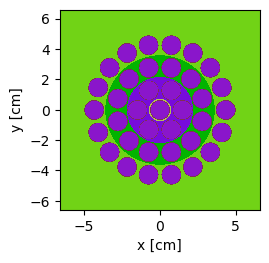

In [11]:
bundle_universe.plot(**plot_args)

In [12]:
pt_inner = openmc.ZCylinder(r=pressure_tube_ir)
pt_outer = openmc.ZCylinder(r=pressure_tube_or)
calendria_inner = openmc.ZCylinder(r=calendria_ir)
calendria_outer = openmc.ZCylinder(r=calendria_or, boundary_type='vacuum')

bundle = openmc.Cell(fill=bundle_universe, region=-pt_inner)
pressure_tube = openmc.Cell(fill=clad, region=+pt_inner & -pt_outer)
v1 = openmc.Cell(region=+pt_outer & -calendria_inner)
calendria = openmc.Cell(fill=clad, region=+calendria_inner & -calendria_outer)

root_universe = openmc.Universe(cells=[bundle, pressure_tube, v1, calendria])

In [13]:
geom = openmc.Geometry(root_universe)
geom.export_to_xml()

mats = openmc.Materials(geom.get_all_materials().values())
mats.export_to_xml()

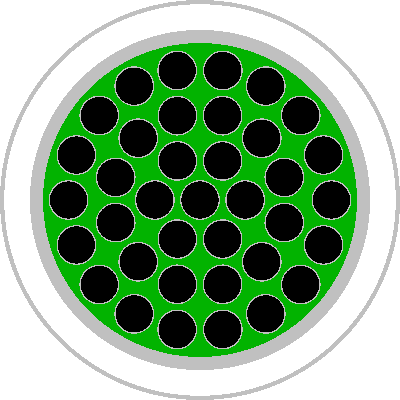

In [14]:
p = openmc.Plot.from_geometry(geom)
p.color_by = 'material'
p.colors = {
    fuel: 'black',
    clad: 'silver',
    coolant: 'blue'
}
openmc.plot_inline(p)

In [15]:
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 100
settings.inactive = 10
settings.source = openmc.IndependentSource(space=openmc.stats.Point())
settings.export_to_xml()

In [ ]:
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell)]
fuel_tally.scores = ['flux']

tallies = openmc.Tallies([fuel_tally])
tallies.export_to_xml()

: 

In [ ]:
model = openmc.Model(geometry=geom, materials=mats, settings=settings)

op = openmc.deplete.CoupledOperator(model)

power = 1200.0e6
timesteps = [0.1, 0.1, 0.1]

integrator = openmc.deplete.PredictorIntegrator(op, timesteps, power)

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading U238 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/U238.h5
 Reading Np237 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Np237.h5
 Reading Pu239 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Pu239.h5
 Reading Pu241 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Pu241.h5
 Reading Am241 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Am241.h5
 Reading Cm245 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cm245.h5
 Reading Zr90 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Zr90.h5
 Reading Zr91 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Zr91.h5
 Reading Zr92 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Zr92.h5
 Reading Zr94 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Zr94.h5
 Reading Zr96 from
 /home/maskedmatters/Documents/Code/TPR/e

[openmc.deplete] t=0.0 s, dt=0.1 s, source=1200000000.0
 Reading H3 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/H3.h5
 Reading He3 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/He3.h5
 Reading He4 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/He4.h5
 Reading Li6 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Li6.h5
 Reading Li7 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Li7.h5
 Reading Be7 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Be7.h5
 Reading Be9 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Be9.h5
 Reading B10 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/B10.h5
 Reading B11 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/B11.h5
 Reading C12 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/C12.h5
 Reading C13 from
 /home/maskedmatte

 Reading Na23 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Na23.h5
 Reading Mg24 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mg24.h5
 Reading Mg25 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mg25.h5
 Reading Mg26 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mg26.h5
 Reading Al26_m1 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Al26_m1.h5
 Reading Al27 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Al27.h5
 Reading Si28 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Si28.h5
 Reading Si29 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Si29.h5
 Reading Si30 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Si30.h5
 Reading Si31 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Si31.h5
 Reading Si32 from
 /home/maskedmatters/Documents/Code/TPR/endfb

 Reading Ar38 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ar38.h5
 Reading Ar39 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ar39.h5
 Reading Ar40 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ar40.h5
 Reading Ar41 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ar41.h5
 Reading K39 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/K39.h5
 Reading K40 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/K40.h5
 Reading K41 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/K41.h5
 Reading Ca40 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ca40.h5
 Reading Ca41 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ca41.h5
 Reading Ca42 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ca42.h5
 Reading Ca43 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5

 Reading Se82 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Se82.h5
 Reading Br79 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Br79.h5
 Reading Br80 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Br80.h5
 Reading Br81 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Br81.h5
 Reading Kr78 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Kr78.h5
 Reading Kr79 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Kr79.h5
 Reading Kr80 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Kr80.h5
 Reading Kr81 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Kr81.h5
 Reading Kr82 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Kr82.h5
 Reading Kr83 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Kr83.h5
 Reading Kr84 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.

 Reading Mo92 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mo92.h5
 Reading Mo93 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mo93.h5
 Reading Mo94 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mo94.h5
 Reading Mo95 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mo95.h5
 Reading Mo96 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mo96.h5
 Reading Mo97 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mo97.h5
 Reading Mo98 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mo98.h5
 Reading Mo99 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mo99.h5
 Reading Mo100 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Mo100.h5
 Reading Tc98 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Tc98.h5


 Reading Tc99 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Tc99.h5
 Reading Ru96 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ru96.h5
 Reading Ru97 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ru97.h5
 Reading Ru98 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ru98.h5
 Reading Ru99 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ru99.h5
 Reading Ru100 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ru100.h5
 Reading Ru101 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ru101.h5
 Reading Ru102 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ru102.h5
 Reading Ru103 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ru103.h5
 Reading Ru104 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ru104.h5
 Reading Ru105 from
 /home/maskedmatters/Documents/Code/TPR/

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd106 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd106.h5
 Reading Cd107 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd107.h5
 Reading Cd108 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd108.h5
 Reading Cd109 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd109.h5
 Reading Cd110 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd110.h5
 Reading Cd111 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd111.h5
 Reading Cd112 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd112.h5
 Reading Cd113 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd113.h5
 Reading Cd114 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd114.h5
 Reading Cd115_m1 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cd115_m1.h5
 Reading Cd116 from
 /home/maskedmatters/Doc

          1200K
          2500K


 Reading Sn124 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Sn124.h5
 Reading Sn125 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Sn125.h5
 Reading Sn126 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Sn126.h5
 Reading Sb121 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Sb121.h5
 Reading Sb122 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Sb122.h5
 Reading Sb123 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Sb123.h5
 Reading Sb124 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Sb124.h5
 Reading Sb125 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Sb125.h5
 Reading Sb126 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Sb126.h5
 Reading Te120 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te120.h5
 Reading Te121 from
 /home/maskedmatters/Documents

          1200K
          2500K


 Reading Te121_m1 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te121_m1.h5
 Reading Te122 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te122.h5
 Reading Te123 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te123.h5
 Reading Te124 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te124.h5
 Reading Te125 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te125.h5
 Reading Te126 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te126.h5
 Reading Te127_m1 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te127_m1.h5
 Reading Te128 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te128.h5
 Reading Te129_m1 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te129_m1.h5
 Reading Te130 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Te130.h5
 Reading Te131 from
 /home/maske

          2500K


 Reading Xe136 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Xe136.h5
 Reading Cs133 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cs133.h5
 Reading Cs134 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cs134.h5
 Reading Cs135 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cs135.h5
 Reading Cs136 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cs136.h5
 Reading Ba130 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba130.h5
 Reading Ba131 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba131.h5


          1200K
          2500K


 Reading Ba132 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba132.h5
 Reading Ba133 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba133.h5
 Reading Ba134 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba134.h5
 Reading Ba135 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba135.h5
 Reading Ba136 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba136.h5
 Reading Ba138 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba138.h5
 Reading Ba139 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba139.h5
 Reading Ba140 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ba140.h5
 Reading La138 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/La138.h5
 Reading La139 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/La139.h5
 Reading La140 from
 /home/maskedmatters/Documents

          1200K
          2500K


 Reading Gd152 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Gd152.h5
 Reading Gd153 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Gd153.h5
 Reading Gd154 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Gd154.h5
 Reading Gd155 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Gd155.h5
 Reading Gd156 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Gd156.h5
 Reading Gd157 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Gd157.h5
 Reading Gd158 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Gd158.h5
 Reading Gd159 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Gd159.h5
 Reading Gd160 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Gd160.h5
 Reading Tb158 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Tb158.h5
 Reading Tb159 from
 /home/maskedmatters/Documents

          1200K
          2500K


 Reading Yb170 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Yb170.h5
 Reading Yb171 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Yb171.h5


          1200K
          2500K
          1200K
          2500K


 Reading Yb172 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Yb172.h5
 Reading Yb173 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Yb173.h5


          1200K
          2500K
          1200K
          2500K


 Reading Yb174 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Yb174.h5
 Reading Yb175 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Yb175.h5


          1200K
          2500K


 Reading Yb176 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Yb176.h5
 Reading Lu175 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Lu175.h5
 Reading Lu176 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Lu176.h5
 Reading Hf174 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Hf174.h5


          1200K
          2500K


 Reading Hf175 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Hf175.h5
 Reading Hf176 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Hf176.h5
 Reading Hf177 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Hf177.h5
 Reading Hf178 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Hf178.h5
 Reading Hf179 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Hf179.h5
 Reading Hf180 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Hf180.h5
 Reading Hf181 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Hf181.h5
 Reading Hf182 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Hf182.h5
 Reading Ta180 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ta180.h5


          1200K
          2500K
          1200K
          2500K


 Reading Ta181 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ta181.h5
 Reading Ta182 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Ta182.h5
 Reading W180 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/W180.h5
 Reading W181 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/W181.h5
 Reading W182 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/W182.h5
 Reading W183 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/W183.h5
 Reading W184 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/W184.h5
 Reading W185 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/W185.h5
 Reading W186 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/W186.h5
 Reading Re185 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Re185.h5
 Reading Re186_m1 from
 /home/maskedmatters/Documents/Code/TPR/e

          1200K


 Reading Cf253 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cf253.h5
 Reading Cf254 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Cf254.h5
 Reading Es251 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Es251.h5
 Reading Es252 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Es252.h5
 Reading Es253 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Es253.h5
 Reading Es254 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Es254.h5
 Reading Es254_m1 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Es254_m1.h5
 Reading Es255 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Es255.h5
 Reading Fm255 from
 /home/maskedmatters/Documents/Code/TPR/endfb-viii.0-hdf5/neutron/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for Sr90
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATI

In [ ]:
sp = openmc.StatePoint('statepoint.{}.h5'.format(settings.batches))

In [ ]:
t = sp.get_tally()
t.get_pandas_dataframe()

In [ ]:
for material in model.materials:
    print(f"Material: {material.name}")
    print(material)